In [1]:
import json
import numpy as np

                      
# the granger toolbox in matlab doesn't allow easy selection of the frequency range to be computed, so we have to select that here
fBounds=(0.1,30)
(fLow, fHigh) = fBounds

# Change .json filename to select animal ID number
IDnumber = 2705

################################################################
##            Standard experiment data sets
loadstring = "data/pyData/{}/{}_Data_S_Notch14_1_granger_1.json"

with open(loadstring.format(IDnumber, IDnumber)) as f:
    data = json.load(f)
S_gcArray1 = np.array(data[0])
S_labels = data[1]

loadstring = "data/pyData/{}/{}_Data_S_Notch14_1_granger_2.json"

with open(loadstring.format(IDnumber, IDnumber)) as f:
    data = json.load(f)
S_gcArray2 = np.array(data[0])

S_gcArray = np.concatenate((S_gcArray1,S_gcArray2), axis = 2)


################################################################
##            Lidocaine experiment data sets
loadstring = "data/pyData/{}/{}_Data_L_Notch14_1_granger.json"

with open(loadstring.format(IDnumber, IDnumber)) as f:
    data = json.load(f)
L_gcArray = np.array(data[0])
L_labels = data[1]

In [2]:
days = np.zeros(len(S_labels['allWindows']['subject']))
for k in range(0, len(S_labels['allWindows']['subject'])):
    days[k] = int(S_labels['allWindows']['subject'][k][6])-1

numDay = int(np.ceil(max(days)))+1

days = np.zeros(len(L_labels['allWindows']['subject']))
for k in range(0, len(L_labels['allWindows']['subject'])):
    days[k] = int(L_labels['allWindows']['subject'][k][6])-1

LnumDay = (int(np.ceil(max(days)))+1)*2

duration = 539
Lduration = 359
    
X_arr = np.zeros((numDay, duration), dtype = int)
Y_arr = np.zeros((numDay, duration), dtype = int)
L_arr = np.zeros((LnumDay, Lduration), dtype = int)
LY_arr = np.zeros((LnumDay, Lduration), dtype = int)
    
for k in range(0, len(S_labels['allWindows']['subject'])):
    d = int(S_labels['allWindows']['subject'][k][6])-1
    w = S_labels['allWindows']['windowID'][k]-1
    if w < duration: 
        X_arr[d, w] = k
        Y_arr[d, w] = S_labels['allWindows']['stimOn'][k]

for k in range(0, len(L_labels['allWindows']['subject'])):
    sham = int('lm' in L_labels['allWindows']['subject'][k])
    d = int(L_labels['allWindows']['subject'][k][6])-1
    w = L_labels['allWindows']['windowID'][k]-1
    if w < Lduration: 
        L_arr[d + sham*3, w] = k
        LY_arr[d + sham*3, w] = L_labels['allWindows']['stimOn'][k]        
        
#X_list = X_arr.reshape(numDay*duration, 1)
#Y_list = Y_arr.reshape(numDay*duration, 1)

#X_all = XS
#Y_all = np.array(S_labels['allWindows']['stimOn'])

In [3]:
arrayData = [S_gcArray, L_gcArray]
days = [numDay, LnumDay]
dur = [duration, Lduration]
arr = [X_arr, L_arr]
each = [[[]], [[], []]]
ave = [[[]], [[], []]]
groups = [1, 2]

record_labels = ['Standard', 'Lidocaine']
freq_dependent = [[], []]
freq_labels = ['Left to Right', 'Right to Left', 'Top to Bottom', 'Bottom to Top']
group_labels = [[''], [' Stim', ' Sham']]

dayrange = [[range(numDay)],[range(int(LnumDay/2)), range(int(LnumDay/2),LnumDay)]]

[P, F, W] = arrayData[0].shape
stimon = [[np.zeros((4, F))], [np.zeros((4, F)), np.zeros((4, F))]]
baseline = [[np.zeros((4, F))], [np.zeros((4, F)), np.zeros((4, F))]]

for r in range(len(arrayData)):
    for g in range(groups[r]):
        [P, F, W] = arrayData[r].shape
        left = np.zeros((days[r], dur[r]))
        right = np.zeros((days[r], dur[r]))
        down = np.zeros((days[r], dur[r]))
        up = np.zeros((days[r], dur[r]))

        gc_day = np.zeros((P, F, dur[r]))
        for d in range(days[r]):
            gc_day = arrayData[r][:, :, arr[r][d, :]]
            left[d, :] = np.mean(np.mean(gc_day[range(60, 120), :, :], axis = 0), axis = 0)
            right[d, :] = np.mean(np.mean(gc_day[range(60), :, :], axis = 0), axis = 0)
            down[d, :] = np.mean(np.mean(gc_day[range(134, 148), :, :], axis = 0), axis = 0)
            up[d, :] = np.mean(np.mean(gc_day[range(120, 148), :, :], axis = 0), axis = 0)

        N = 20
        ave[r][g] = np.zeros((4, dur[r]))
        wS = np.arange(0, dur[r]-N+1) + (N-2)

        for k in range(4):
            each[r][g] = [left[dayrange[r][g], :], right[dayrange[r][g], :], down[dayrange[r][g], :], up[dayrange[r][g], :]]
            for d in range(len(dayrange[r][g])):
                cumsum, moving_aves = [0], []
                for i, x in enumerate(each[r][g][k][d, :], 1):
                    cumsum.append(cumsum[i-1] + x)
                    if i >= N:
                        moving_ave = (cumsum[i] - cumsum[i-N])/N
                        moving_aves.append(moving_ave)
                each[r][g][k][d, wS] = moving_aves
            ave[r][g][k, :] = np.mean(each[r][g][k], axis = 0)
        
    gc_day = np.zeros((days[r], P, F, dur[r]))
    for d in range(days[r]):
        gc_day[d, :, :, :] = arrayData[r][:, :, arr[r][d, :]]
    
    freq_dependent[r] = [[[], [], [], []] for _ in range(groups[r])]
    for g in range(groups[r]):
        freq_dependent[r][g][0] = np.mean(np.mean(gc_day[dayrange[r][g], 60:120, :], axis = 0), axis = 0)
        freq_dependent[r][g][1] = np.mean(np.mean(gc_day[dayrange[r][g], :60, :], axis = 0), axis = 0)
        freq_dependent[r][g][2] = np.mean(np.mean(gc_day[dayrange[r][g], 134:148, :], axis = 0), axis = 0)
        freq_dependent[r][g][3] = np.mean(np.mean(gc_day[dayrange[r][g], 120:134, :], axis = 0), axis = 0)
        
        for i in range(4):
            stimon[r][g][i, :] = np.mean([np.mean(freq_dependent[r][g][i][:, range(180, 270)], axis = 1), np.mean(freq_dependent[r][g][i][:, range(180, 270)], axis = 1)], axis = 0)
            baseline[r][g][i, :] = np.mean(freq_dependent[r][g][i][:, range(0, 180)], axis = 1)

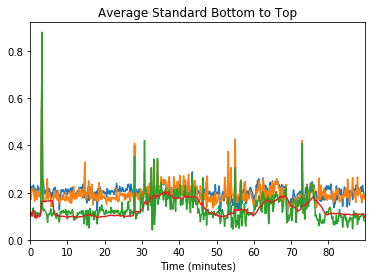

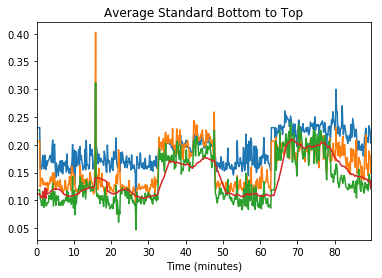

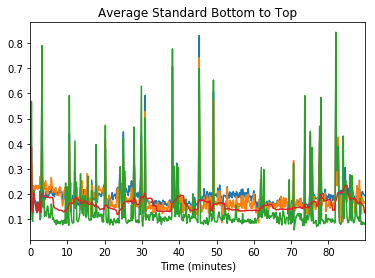

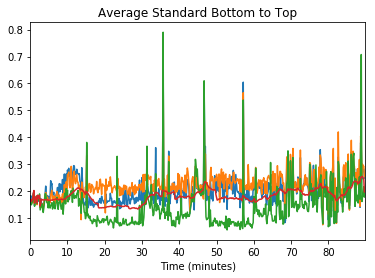

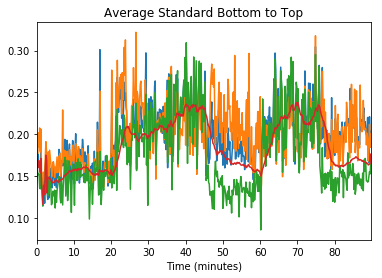

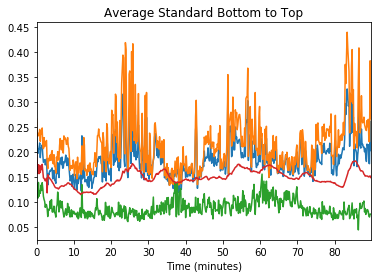

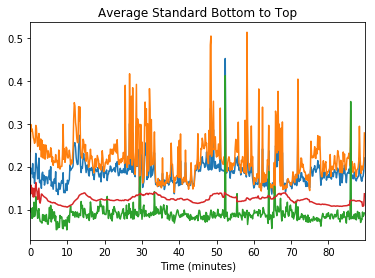

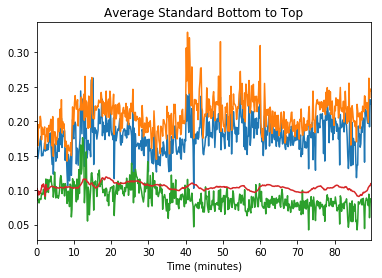

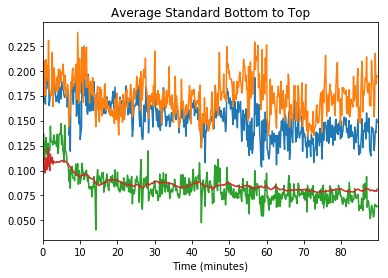

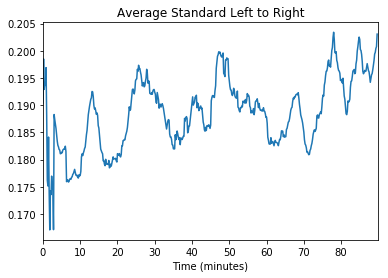

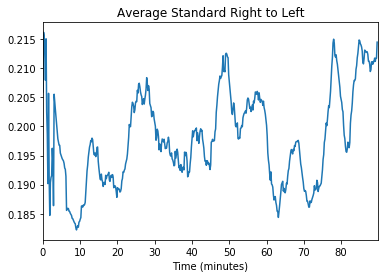

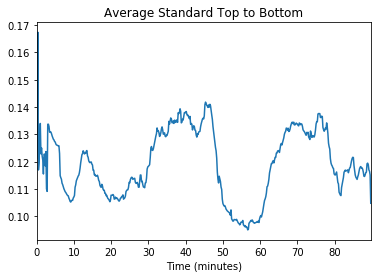

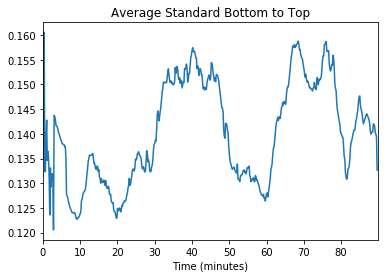

In [4]:
import matplotlib.pyplot as plt
r = 0
for g in range(groups[r]):
    for d in range(days[g]):
        for i in range(4):  
            plt.plot(np.arange(dur[r])/6, each[r][g][i][d])
            plt.xlim([0, dur[r]/6])
            plt.xlabel('Time (minutes)')
            plt.title('Average ' + record_labels[r] + group_labels[r][g] + ' ' + freq_labels[i])
        plt.show()
        
        
for g in range(groups[r]):
    for i in range(4):  
        plt.plot(np.arange(dur[r])/6, ave[r][g][i,:])
        plt.xlim([0, dur[r]/6])
        plt.xlabel('Time (minutes)')
        plt.title('Average ' + record_labels[r] + group_labels[r][g] + ' ' + freq_labels[i])
        plt.show()

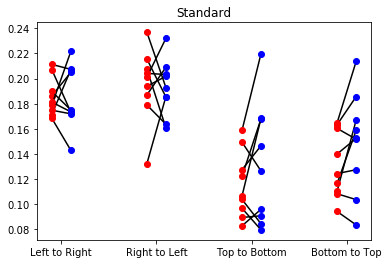

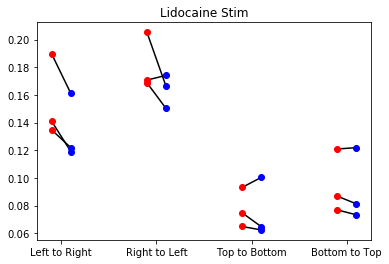

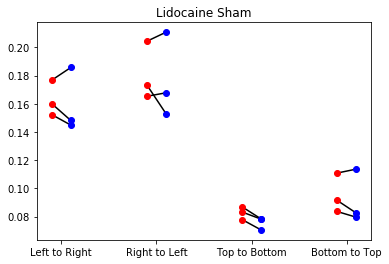

In [5]:
baseline = np.arange(0, 180)
SNS1 = np.arange(180, 270)
SNS2 = np.arange(360, 450)
SNS = np.concatenate((SNS1, SNS2))

snsgrp = [SNS, SNS1]

sns = [[[]], [[], []]];
bsl = [[[]], [[], []]];

for r in range(2):
    for g in range(groups[r]):
        sns[r][g] = np.zeros((4, days[r]))
        bsl[r][g] = np.zeros((4, days[r]))
        plt.figure()
        for i in range(4):  
            for d in range(len(dayrange[r][g])):
                sns[r][g][i, d] = np.mean(each[r][g][i][d][snsgrp[r]])
                bsl[r][g][i, d] = np.mean(each[r][g][i][d][baseline])

                plt.plot([i, i+0.2], [bsl[r][g][i, d], sns[r][g][i, d]], 'k-')
                plt.plot(i, bsl[r][g][i, d], 'ro')
                plt.plot(i+0.2, sns[r][g][i, d], 'bo')
        plt.title(record_labels[r] + group_labels[r][g])        
        plt.xticks([0.1, 1.1, 2.1, 3.1], freq_labels)
        plt.show()

In [6]:
for r in range(2):    
    for g in range(groups[r]):
        for i in range(4):  
            for d in range(len(dayrange[r][g])):
                print(str(IDnumber) + ',' + record_labels[r] + group_labels[r][g] + ',' + freq_labels[i] + ',' + str(d+1) + ',' + str(bsl[r][g][i, d]) + ',' + str(sns[r][g][i, d]))

2705,Standard,Left to Right,1,0.21131610899,0.207343020091
2705,Standard,Left to Right,2,0.171317929231,0.207121062822
2705,Standard,Left to Right,3,0.207208584938,0.173225133855
2705,Standard,Left to Right,4,0.186220631482,0.204904755557
2705,Standard,Left to Right,5,0.178735147408,0.22160836248
2705,Standard,Left to Right,6,0.181256546949,0.173498203735
2705,Standard,Left to Right,7,0.189757362585,0.174981613188
2705,Standard,Left to Right,8,0.174785773933,0.171917145837
2705,Standard,Left to Right,9,0.168389490351,0.142873957058
2705,Standard,Right to Left,1,0.193882904711,0.201838807737
2705,Standard,Right to Left,2,0.13220837035,0.185709154103
2705,Standard,Right to Left,3,0.20743701614,0.160688022299
2705,Standard,Right to Left,4,0.201126824626,0.232095477664
2705,Standard,Right to Left,5,0.186977117808,0.209042930541
2705,Standard,Right to Left,6,0.215570670793,0.185263699046
2705,Standard,Right to Left,7,0.236918494553,0.192802526826
2705,Standard,Right to Left,8,0.204132920232

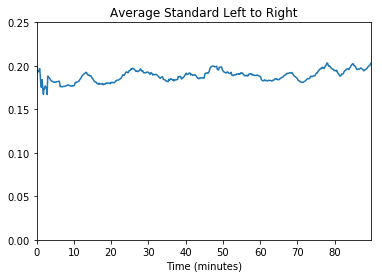

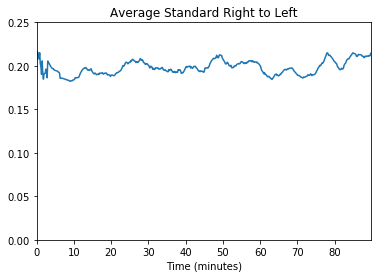

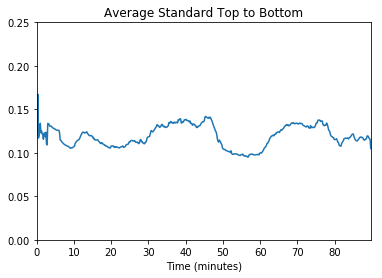

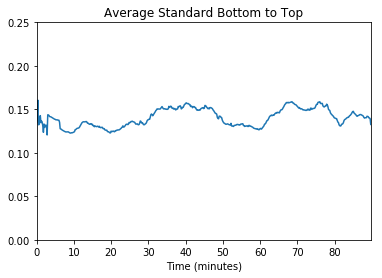

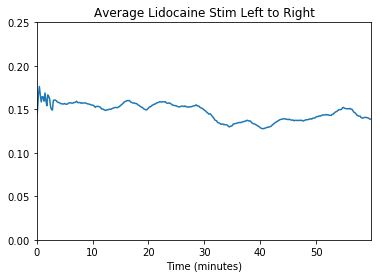

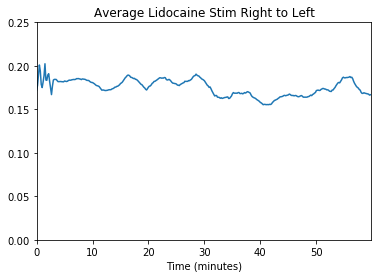

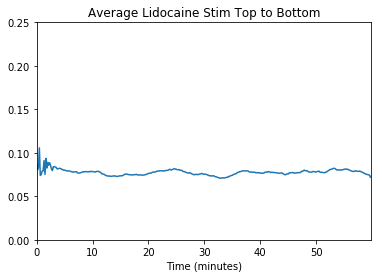

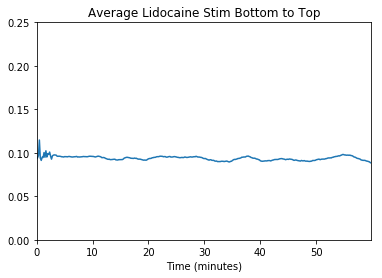

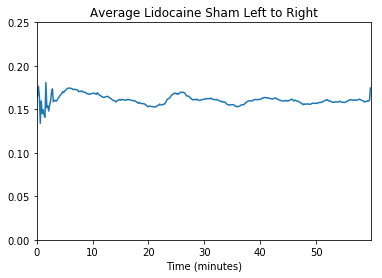

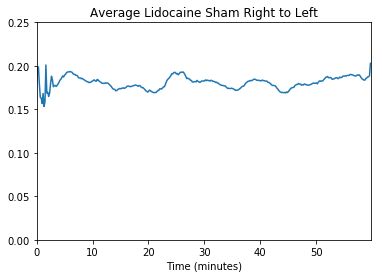

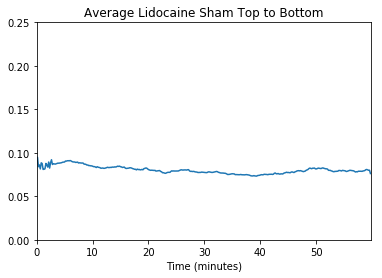

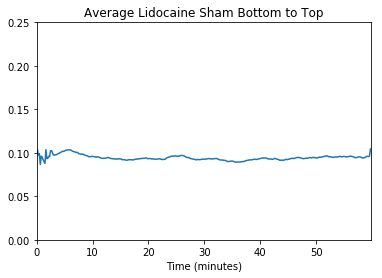

In [7]:
for r in range(2):
    for g in range(groups[r]):
        for i in range(4):  
            plt.plot(np.arange(dur[r])/6, ave[r][g][i, :])
            plt.xlim([0, dur[r]/6])
            plt.ylim([0, 0.25])
            plt.xlabel('Time (minutes)')
            plt.title('Average ' + record_labels[r] + group_labels[r][g] + ' ' + freq_labels[i])
            plt.show()

In [8]:
import csv
with open('example.csv', 'w') as csvfile:
    fieldnames = ['Window', 'Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for w in range(duration):
        writer.writerow({'Window': w, 'Day 1': each[0][0][3][0][w], 'Day 2': each[0][0][3][1][w], 'Day 3': each[0][0][3][2][w], 'Day 4': each[0][0][3][3][w], 'Day 5': each[0][0][3][4][w], 'Day 6': each[0][0][3][5][w], 'Day 7': each[0][0][3][6][w], 'Day 8': each[0][0][3][7][w], 'Day 9': each[0][0][3][8][w]})
        
with open('lidoexample.csv', 'w') as csvfile:
    fieldnames = ['Window', 'Day 1', 'Day 2', 'Day 3']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for w in range(Lduration):
        writer.writerow({'Window': w, 'Day 1': each[1][0][3][0][w], 'Day 2': each[1][0][3][1][w], 'Day 3': each[1][0][3][2][w]})

arrayData = ['S': S_gcArray, 'L': L_gcArray]


[P, F, W] = S_gcArray.shape

left = np.zeros((numDay, duration))
right = np.zeros((numDay, duration))
down = np.zeros((numDay, duration))
up = np.zeros((numDay, duration))

for d in range(numDay):
    S_gcArray_day = S_gcArray[:,:,X_arr[d,:]]
    left[d,:] = np.mean(np.mean(S_gcArray_day[range(60),:,:], axis = 0), axis = 0)
    right[d,:] = np.mean(np.mean(S_gcArray_day[range(60,120),:,:], axis = 0), axis = 0)
    down[d,:] = np.mean(np.mean(S_gcArray_day[range(120,134),:,:], axis = 0), axis = 0)
    up[d,:] = np.mean(np.mean(S_gcArray_day[range(134,148),:,:], axis = 0), axis = 0)

N = 5
each = [left, right, down, up]
ave = np.zeros((4, duration))
wS = np.arange(0, duration-N+1) + (N-2)

for k in range(4):
    for d in range(numDay):
        cumsum, moving_aves = [0], []
        for i, x in enumerate(each[k][d,:], 1):
            cumsum.append(cumsum[i-1] + x)
            if i >= N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        each[k][d, wS] = moving_aves
    ave[k,:] = np.mean(each[k], axis = 0)


[P, F, W] = L_gcArray.shape

Lleft = np.zeros((LnumDay, Lduration))
Lright = np.zeros((LnumDay, Lduration))
Ldown = np.zeros((LnumDay, Lduration))
Lup = np.zeros((LnumDay, Lduration))

for d in range(LnumDay):
    L_gcArray_day = L_gcArray[:,:,L_arr[d,:]]
    Lleft[d,:] = np.mean(np.mean(L_gcArray_day[range(60),:,:], axis = 0), axis = 0)
    Lright[d,:] = np.mean(np.mean(L_gcArray_day[range(60,120),:,:], axis = 0), axis = 0)
    Ldown[d,:] = np.mean(np.mean(L_gcArray_day[range(120,134),:,:], axis = 0), axis = 0)
    Lup[d,:] = np.mean(np.mean(L_gcArray_day[range(134,148),:,:], axis = 0), axis = 0)

N = 5
Leach = [Lleft, Lright, Ldown, Lup]
Lave = np.zeros((4, Lduration))
wS = np.arange(0, Lduration-N+1) + (N-2)

for k in range(4):
    for d in range(LnumDay):
        cumsum, moving_aves = [0], []
        for i, x in enumerate(Leach[k][d,:], 1):
            cumsum.append(cumsum[i-1] + x)
            if i >= N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        Leach[k][d, wS] = moving_aves
    Lave[k,:] = np.mean(Leach[k], axis = 0)

S_gcArray_day = np.zeros((numDay, P, F, duration))
for d in range(numDay):
    S_gcArray_day[d,:,:,:] = S_gcArray[:,:,X_arr[d,:]]

left_freq = np.mean(np.mean(S_gcArray_day[:, :60, :], axis = 0), axis = 0)
right_freq = np.mean(np.mean(S_gcArray_day[:, 60:120, :], axis = 0), axis = 0)
down_freq = np.mean(np.mean(S_gcArray_day[:, 120:134, :], axis = 0), axis = 0)
up_freq = np.mean(np.mean(S_gcArray_day[:, 134:148, :], axis = 0), axis = 0)
all_dir = np.mean(np.mean(S_gcArray_day, axis = 0), axis = 0)

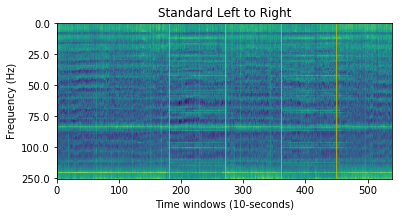

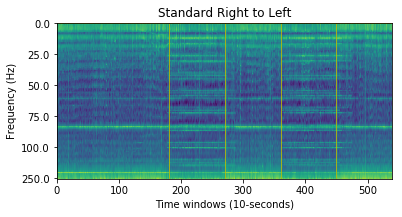

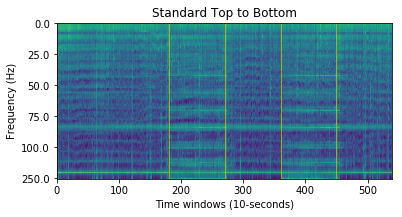

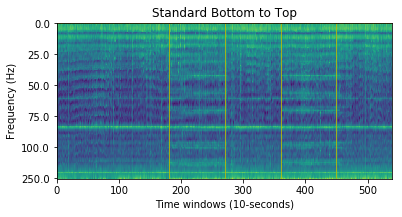

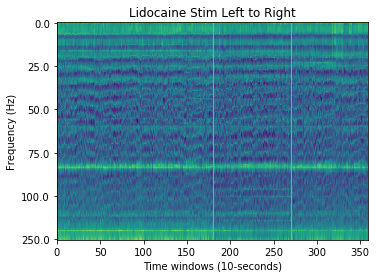

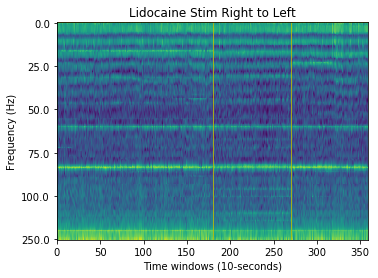

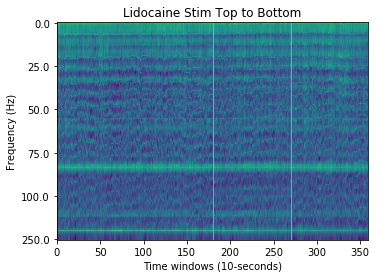

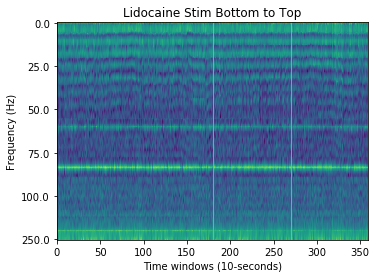

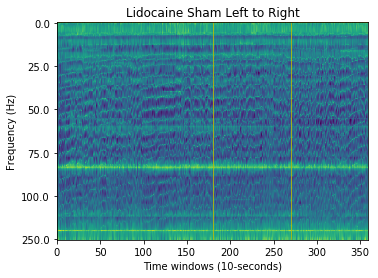

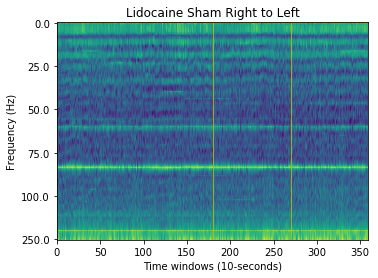

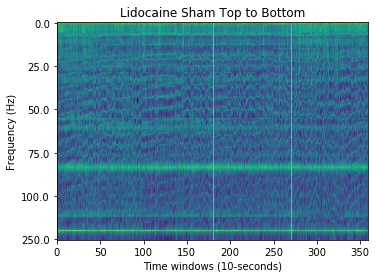

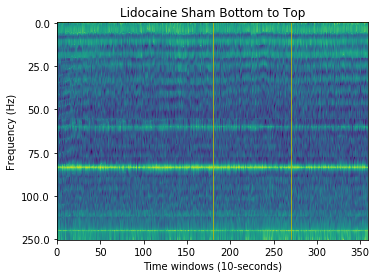

In [9]:
freq = np.zeros(6)
freq[:5] = np.array(S_labels['f'])[0:250:50]-0.5
freq[5] = 250
for r in range(len(arrayData)):
    for g in range(groups[r]):
        for i in range(4):
            fig, ax = plt.subplots()
            im = ax.imshow(np.log(freq_dependent[r][g][i]))
            plt.plot([180, 180],[0, 250], color = 'y', linewidth = 0.8)
            plt.plot([270, 270],[0, 250], color = 'y', linewidth = 0.8)
            plt.plot([360, 360],[0, 250], color = 'y', linewidth = 0.8)
            plt.plot([450, 450],[0, 250], color = 'y', linewidth = 0.8)
            plt.xlim([0, dur[r]])
            plt.xlabel('Time windows (10-seconds)')
            plt.yticks(np.arange(251)[0:251:50], freq)
            plt.ylabel('Frequency (Hz)')
            plt.title(record_labels[r] + group_labels[r][g] + ' ' + freq_labels[i])
            plt.show()

In [10]:
for r in range(len(arrayData)):
    for g in range(groups[r]):
        for i in range(4):
            plt.figure()
            plt.plot(S_labels['f'], baseline[r][g][i, range(250)], color = 'b')
            plt.plot(S_labels['f'], stimon[r][g][i, range(250)], color = 'r')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Granger Causality')
            plt.xlim([0, np.max(S_labels['f'])])
            plt.ylim([0, 1.2])
            plt.title(record_labels[r] + group_labels[r][g] + ' ' + freq_labels[i])
            plt.legend(['Baseline','Stimulation ON'])
            plt.show()
            
            plt.figure()
            plt.plot(np.arange(dur[r])/6, ave[r][g][i,:])
            plt.xlim([0, dur[r]/6])
            plt.xlabel('Time (minutes)')
            plt.title('Average ' + record_labels[r] + group_labels[r][g] + ' ' + freq_labels[i])
            plt.show()

IndexError: invalid index to scalar variable.

In [ ]:
for r in range(len(arrayData)):
    for g in range(groups[r]):
        for i in range(4):
            plt.plot([0, np.max(S_labels['f'])], [0,0], color = 'k', linestyle = '--', linewidth = 0.5)
            for j in range(int(np.max(S_labels['f'])/14)+1):
                plt.plot([14*j, 14*j],[-0.35, 0.3], color = 'k', linestyle = ':',linewidth = 0.5)
                
            plt.plot(S_labels['f'], stimon[r][g][i, range(250)] - baseline[r][g][i, range(250)])
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Granger Causality (StimON - Baseline)')
            plt.xlim([0, np.max(S_labels['f'])])
            plt.ylim([-0.35, 0.3])
            plt.title(record_labels[r] + group_labels[r][g] + ' ' + freq_labels[i])
            plt.show()